In [10]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
# Load dataset CSV
df = pd.read_csv('dataset/dataset.csv')

# Check the first few rows to ensure data is loaded properly
print(df.head())

# Function to load and preprocess images
def load_images_and_labels(df, img_size=(128, 128)):
    images = []
    labels = []
    
    for index, row in df.iterrows():
        img_path = row['Image_Path']
        label = row['Category']
        
        # Load image as grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, img_size)
        img = img / 255.0  # Normalize to [0, 1]
        
        # Duplicate grayscale to 3 channels to match VGG16 input shape
        img = np.repeat(img[..., np.newaxis], 3, axis=-1)  # Convert (128, 128, 1) to (128, 128, 3)
        
        images.append(img)
        labels.append(label)
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Load images and labels from the CSV
X, y = load_images_and_labels(df)

# Print image shape and label distribution
print(X.shape, y[:5])

         Category            Subcategory  \
0  BANANA DISEASE  RESIZED BANANA APHIDS   
1  BANANA DISEASE  RESIZED BANANA APHIDS   
2  BANANA DISEASE  RESIZED BANANA APHIDS   
3  BANANA DISEASE  RESIZED BANANA APHIDS   
4  BANANA DISEASE  RESIZED BANANA APHIDS   

                                          Image_Path  
0  dataset/BANANA DISEASE/RESIZED BANANA APHIDS/B...  
1  dataset/BANANA DISEASE/RESIZED BANANA APHIDS/B...  
2  dataset/BANANA DISEASE/RESIZED BANANA APHIDS/B...  
3  dataset/BANANA DISEASE/RESIZED BANANA APHIDS/B...  
4  dataset/BANANA DISEASE/RESIZED BANANA APHIDS/B...  
(3876, 128, 128, 3) ['BANANA DISEASE' 'BANANA DISEASE' 'BANANA DISEASE' 'BANANA DISEASE'
 'BANANA DISEASE']


Label distribution after encoding:
0    2346
1    1530
Name: count, dtype: int64


c:\Users\MSI\Desktop\projects\Banana plant disease detection\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Label distribution after SMOTE:
0    2346
1    2346
Name: count, dtype: int64
Training data class distribution:
1    1884
0    1869
Name: count, dtype: int64


C:\Users\MSI\AppData\Local\Temp\ipykernel_6896\4200611745.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


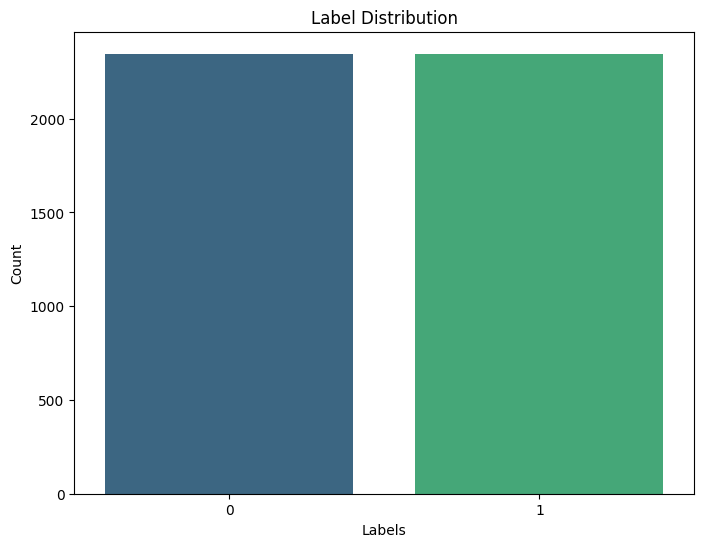

Training data size: (3753, 128, 128, 3), Test data size: (939, 128, 128, 3)


In [12]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the label distribution after encoding
print("Label distribution after encoding:")
print(pd.Series(y_encoded).value_counts())

# Ensure the classes are imbalanced with more 0's than 1's
# Apply SMOTE to balance the classes by oversampling class 1
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.reshape(X.shape[0], -1), y_encoded)  # Reshape X for SMOTE

# Reshape X back to its original shape after SMOTE
X_resampled = X_resampled.reshape(-1, 128, 128, 3)

# Check the label distribution after applying SMOTE
print("Label distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Check the training data class distribution
print("Training data class distribution:")
print(pd.Series(y_train).value_counts())

# Plotting label distribution
def plot_label_distribution(labels):
    # Convert the labels into a pandas Series and count their occurrences
    label_counts = pd.Series(labels).value_counts()
    
    # Create a seaborn barplot
    plt.figure(figsize=(8, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    
    # Labeling the axes
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    
    # Display the plot
    plt.show()

plot_label_distribution(y_resampled)

print(f"Training data size: {X_train.shape}, Test data size: {X_test.shape}")

In [13]:
import pickle

# Assuming you have already fitted your LabelEncoder (e.g., label_encoder)
with open('category_label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

print("LabelEncoder has been saved successfully.")

LabelEncoder has been saved successfully.


In [14]:
def create_cnn_model(input_shape=(128, 128, 1), num_classes=5):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
cnn_model = create_cnn_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_encoded)))

# Train the CNN model
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save the model if needed
cnn_model.save('category_banana_cnn_model.h5')

c:\Users\MSI\Desktop\projects\Banana plant disease detection\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 42s 312ms/step - accuracy: 0.6854 - loss: 2.5303 - val_accuracy: 0.5463 - val_loss: 3.3693
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 293ms/step - accuracy: 0.8135 - loss: 0.5150 - val_accuracy: 0.6944 - val_loss: 1.0369
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 299ms/step - accuracy: 0.8430 - loss: 0.4428 - val_accuracy: 0.7508 - val_loss: 0.7426
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 294ms/step - accuracy: 0.8687 - loss: 0.3376 - val_accuracy: 0.6560 - val_loss: 1.6588
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 299ms/step - accuracy: 0.8842 - loss: 0.2576 - val_accuracy: 0.8435 - val_loss: 0.3086
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 35s 295ms/step - accuracy: 0.8929 - loss: 0.2383 - val_accuracy: 0.9052 - val_loss: 0.2252
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 291ms/step - accuracy: 0.9181 - loss: 0.1961 - val_accuracy: 0.8477 - val_loss: 0.3721
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 34s 286ms/step - accuracy: 0.9130 - loss: 0

In [15]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test)
print(f"CNN Model Accuracy: {cnn_test_acc * 100:.2f}%")

# Predict using the trained model
cnn_predictions = cnn_model.predict(X_test)
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)

# Print the classification report and confusion matrix
print(classification_report(y_test, cnn_pred_labels))
print(confusion_matrix(y_test, cnn_pred_labels))

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.8675 - loss: 0.3346
CNN Model Accuracy: 86.79%
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       477
           1       0.94      0.78      0.85       462

    accuracy                           0.87       939
   macro avg       0.88      0.87      0.87       939
weighted avg       0.88      0.87      0.87       939

[[455  22]
 [102 360]]


In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

def create_vgg16_model(input_shape=(128, 128, 3), num_classes=5):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model layers
    
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the VGG16-based model without ImageDataGenerator
vgg16_model = create_vgg16_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_encoded)))

# Train the VGG16 model directly on the data
vgg16_history = vgg16_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the VGG16 model
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(X_test, y_test)
print(f"VGG16 Model Accuracy: {vgg16_test_acc * 100:.2f}%")

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.7777 - loss: 0.5436 - val_accuracy: 0.9073 - val_loss: 0.2039
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.9432 - loss: 0.1506 - val_accuracy: 0.8626 - val_loss: 0.3762
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9338 - loss: 0.1606 - val_accuracy: 0.9148 - val_loss: 0.2223
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 417s 4s/step - accuracy: 0.9327 - loss: 0.1754 - val_accuracy: 0.9084 - val_loss: 0.2097
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 685s 6s/step - accuracy: 0.9527 - loss: 0.1057 - val_accuracy: 0.8988 - val_loss: 0.2473
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9511 - loss: 0.0977 - val_accuracy: 0.9297 - val_loss: 0.2059
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.9594 - loss: 0.1006 - val_accuracy: 0.8956 - val_loss: 0.3352
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9597 - loss: 0.1012 - val_accu

In [17]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

def create_resnet50_model(input_shape=(128, 128, 3), num_classes=5):
    # Load ResNet50 pre-trained model without the top classification layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Initially freeze the base model layers
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and train the ResNet50-based model without ImageDataGenerator
resnet50_model = create_resnet50_model(input_shape=X_train.shape[1:], num_classes=len(np.unique(y_encoded)))

# Train the ResNet50 model directly on the data
resnet50_history = resnet50_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the ResNet50 model
resnet50_test_loss, resnet50_test_acc = resnet50_model.evaluate(X_test, y_test)
print(f"ResNet50 Model Accuracy: {resnet50_test_acc * 100:.2f}%")


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 105s 731ms/step - accuracy: 0.6094 - loss: 0.6717 - val_accuracy: 0.7029 - val_loss: 0.5435
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 90s 764ms/step - accuracy: 0.7245 - loss: 0.5273 - val_accuracy: 0.7188 - val_loss: 0.5453
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 91s 770ms/step - accuracy: 0.7241 - loss: 0.5257 - val_accuracy: 0.7316 - val_loss: 0.5112
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 92s 779ms/step - accuracy: 0.7406 - loss: 0.4943 - val_accuracy: 0.7401 - val_loss: 0.4855
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 91s 771ms/step - accuracy: 0.7634 - loss: 0.4537 - val_accuracy: 0.7657 - val_loss: 0.4615
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 142s 765ms/step - accuracy: 0.7689 - loss: 0.4407 - val_accuracy: 0.7796 - val_loss: 0.4454
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 92s 777ms/step - accuracy: 0.7819 - loss: 0.4274 - val_accuracy: 0.7977 - val_loss: 0.4368
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 140s 761ms/step - accuracy: 0.7889 - loss

In [18]:
# Fine-tune VGG16
vgg16_model.trainable = True  # Unfreeze VGG16 base model
for layer in vgg16_model.layers[:15]:  # Freeze the first 15 layers
    layer.trainable = False

# Fine-tune VGG16 model directly on the data
vgg16_finetune_history = vgg16_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Fine-tune VGG16 model evaluation
vgg16_finetune_loss, vgg16_finetune_acc = vgg16_model.evaluate(X_test, y_test)
print(f"Fine-tuned VGG16 Model Accuracy: {vgg16_finetune_acc * 100:.2f}%")

# Predict using the fine-tuned VGG16 model
vgg16_finetune_predictions = vgg16_model.predict(X_test)
vgg16_finetune_pred_labels = np.argmax(vgg16_finetune_predictions, axis=1)

# Print the classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, vgg16_finetune_pred_labels))
print(confusion_matrix(y_test, vgg16_finetune_pred_labels))

# Fine-tune ResNet50
resnet50_model.trainable = True  # Unfreeze ResNet50 base model
for layer in resnet50_model.layers[:100]:  # Freeze the first 100 layers
    layer.trainable = False

# Fine-tune ResNet50 model directly on the data
resnet50_finetune_history = resnet50_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Fine-tune ResNet50 model evaluation
resnet50_finetune_loss, resnet50_finetune_acc = resnet50_model.evaluate(X_test, y_test)
print(f"Fine-tuned ResNet50 Model Accuracy: {resnet50_finetune_acc * 100:.2f}%")


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9597 - loss: 0.0882 - val_accuracy: 0.9084 - val_loss: 0.1902
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9544 - loss: 0.1059 - val_accuracy: 0.9255 - val_loss: 0.1870
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9655 - loss: 0.0758 - val_accuracy: 0.9180 - val_loss: 0.1944
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9579 - loss: 0.0844 - val_accuracy: 0.9169 - val_loss: 0.2287
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9661 - loss: 0.0736 - val_accuracy: 0.9255 - val_loss: 0.2125
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9633 - loss: 0.0745 - val_accuracy: 0.9276 - val_loss: 0.1899
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9646 - loss: 0.0819 - val_accuracy: 0.9265 - val_loss: 0.1823
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9653 - loss: 0.0788 - val_accu

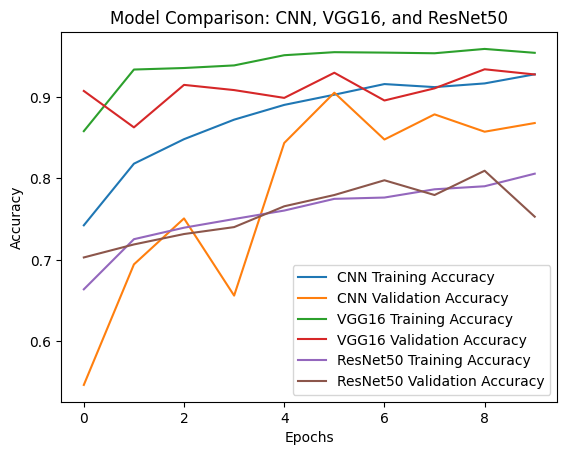

CNN Test Accuracy: 86.79%
VGG16 Test Accuracy: 92.76%
ResNet50 Test Accuracy: 75.29%


In [19]:
# Plot training history for all three models
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(vgg16_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.plot(resnet50_history.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='ResNet50 Validation Accuracy')

plt.title('Model Comparison: CNN, VGG16, and ResNet50')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compare final accuracy for all three models
print(f"CNN Test Accuracy: {cnn_test_acc * 100:.2f}%")
print(f"VGG16 Test Accuracy: {vgg16_test_acc * 100:.2f}%")
print(f"ResNet50 Test Accuracy: {resnet50_test_acc * 100:.2f}%")

In [20]:
vgg16_model.save('category_banana_vgg16_model.h5')